# 🎯 **Introduction to Darts: A Time Series Library** 📈

🔍 **What is Darts?**
Darts is an amazing Python library that specializes in time series analysis and forecasting. 🕒 It provides a wide range of functionality and tools for working with time series data, making it an essential package for anyone interested in exploring and modeling temporal patterns. 💪

🌟 **Why is Darts Good?**
Darts stands out for several reasons:

1. **User-Friendly**: Darts is designed to be beginner-friendly, making it accessible to students and researchers new to time series analysis. 📚

2. **Extensive Functionality**: It offers a vast array of tools, models, and algorithms for time series manipulation, forecasting, and evaluation. 🧰

3. **Integration with Pandas**: Darts seamlessly integrates with the widely-used pandas library, allowing users to leverage the power of Pandas' DataFrames for time series handling. 🐼

4. **Visualization Capabilities**: Darts provides intuitive plotting functions, enabling users to visualize time series and forecasted values effortlessly. 📊

5. **Modularity and Extendability**: Darts follows a modular design, making it easy to combine and extend functionalities, enabling users to experiment with different models and techniques. 🧩

### Set-up:

💀💀💀 If you are working with an M1/ M2 chip you'll need to run this notebook on Colab since Darts does not yet work on silicon architecture! 💀💀💀

In [ ]:
!pip install darts --quiet

import darts
print(f"Darts version: {darts.__version__}")


Darts version: 0.24.0


2. **Loading and Visualizing Time Series Data with Pandas and Darts** 📊
   - Import the necessary libraries.
   - Load sample [weather](https://wagon-public-datasets.s3.amazonaws.com/weather.csv) and [ice cream](https://wagon-public-datasets.s3.amazonaws.com/ice_cream.csv) time series dataset. This is pulled from [Google Trends](https://trends.google.com/trends/)! We've just taken data for searches on "ice cream" and "hot weather" from 2004. Feel free to check out your own data-sets down the line!
   - Demonstrate how to create a Darts TimeSeries object from a Pandas DataFrame.
   - Plot the time series using Darts' visualization capabilities.

In [ ]:
import pandas as pd

# Load a sample time series dataset
# Skip the first 2 rows when reading the CSV
df = pd.read_csv("ice_cream.csv", header=1, names=['Month', 'ice_cream'])
print(df.shape)
df.head()

(235, 2)


,Month,ice_cream
0,2004-01,12.0
1,2004-02,13.0
2,2004-03,14.0
3,2004-04,16.0
4,2004-05,20.0


First up let's see how easy it is to load up our time series in a TimeSeries object and plot it!

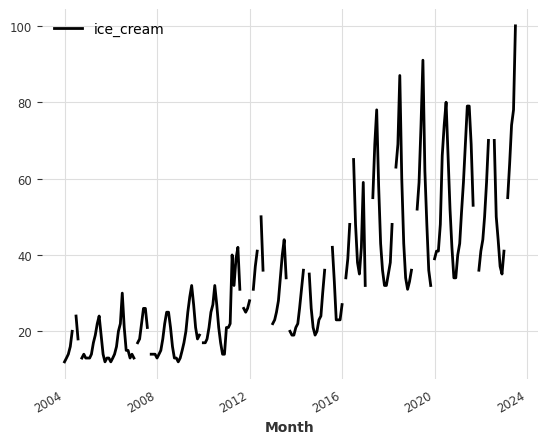

In [ ]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(df, 'Month', 'ice_cream')
series.plot()

Uh oh - looks like we have some issues and missing values 😔 This is a super common issue with many time series! Let's move on to preprocessing to showcase some methods for handling issues like these!

### **Manipulating Time Series Data** 🔄
   - Showcase various operations for manipulating time series data:
     - Resampling and frequency conversion.
     - Handling missing values.
     - Applying rolling window calculations.
     - Feature engineering.

In [ ]:
from darts.utils.missing_values import fill_missing_values
series = fill_missing_values(series)

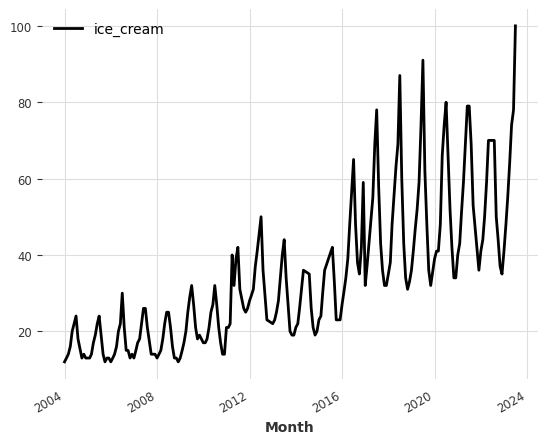

In [ ]:
series.plot()

Easy! What if we want to plot our data on an annual basis instead? We can just resample!

In [ ]:
# Resampling and frequency conversion
resampled_example = series.resample("Y")

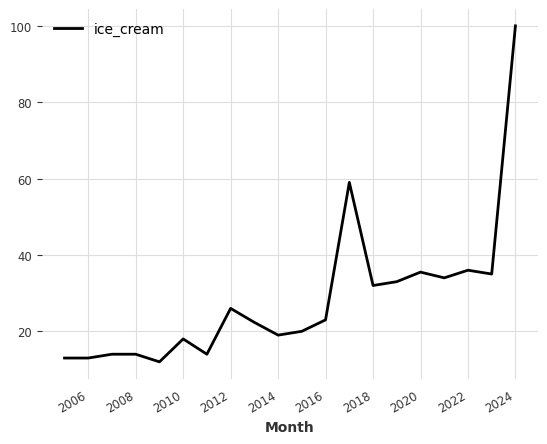

In [ ]:
resampled_example.plot()

In [ ]:
# Applying rolling window calculations
rolling_mean_example = series.window_transform({"function":"mean", "window": 6})

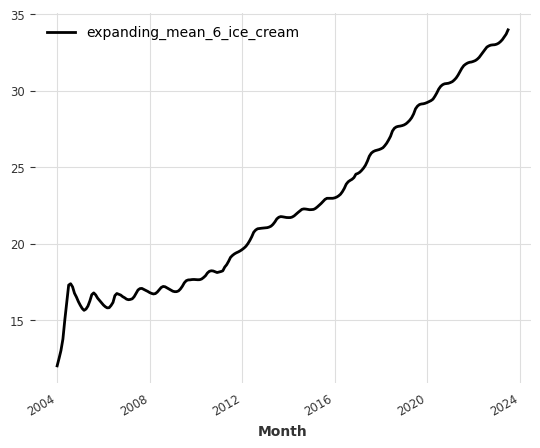

In [ ]:
rolling_mean_example.plot()

We can diff our series just like we did with Pandas earlier

In [ ]:
# Feature engineering
diff_example = series.diff()

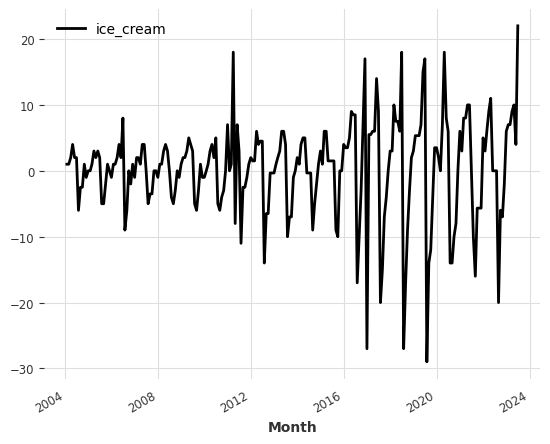

In [ ]:
diff_example.plot()

We can even add holidays to our time series with a quick method - this will add a simple 0 or 1 based on whether or not there was a national holiday on that day. If we wanted, we can then use this to spot more correlations later!

In [ ]:
hol_example = series.add_holidays("US")

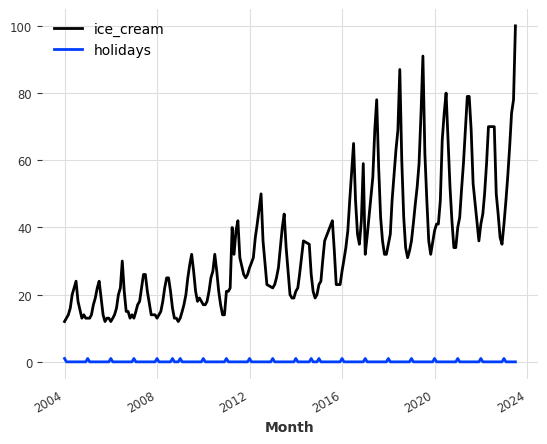

In [ ]:
hol_example.plot()

### Time Series Modeling and Forecasting ⏳
   - Now we can split our data and begin modelling:
     - Naive models (e.g., NaiveSeasonal).
     - Classical models (e.g., ExponentialSmoothing).
     - Machine learning models (e.g., Prophet, ARIMA).
   - Demonstrate how to fit models to time series data and generate forecasts.

First let's standardize and log our time series since it seems to have an exponential trend

In [ ]:
import numpy as np
logged = (series).map(lambda x: np.log(x))

In [ ]:
from darts.dataprocessing.transformers.scaler import Scaler

Next we can easily implement a MinMaxScaler() for our data (in this case - all Google Trends are standardized to 100 so we could just divide by 100, but it's useful to demonstrate!)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
ts_transformer = Scaler(scaler)

In [ ]:
scaled_ts = ts_transformer.fit_transform(logged)

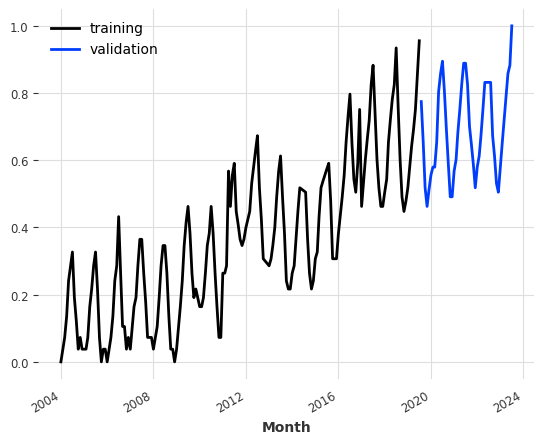

In [ ]:
train, val = (scaled_ts).split_before(0.8)# (we standardize by dividing by 100 since Google Trends data tops out at 100 by default!)
train.plot(label="training")
val.plot(label="validation")

First, let's define our baseline model with a NaiveSeasonal model (when K = 1 it will simply repeat the prior timestep!)

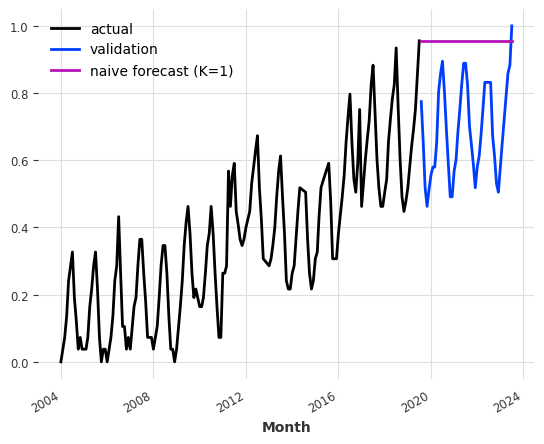

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

train.plot(label="actual")
val.plot(label = "validation")
naive_forecast.plot(label="naive forecast (K=1)")

Not great! Let's quantify our baseline with MAPE.

In [ ]:
from darts.metrics import mape

accuracy = mape(val, naive_forecast)
print(f"Mean Absolute Percentage Error: {accuracy}")

Mean Absolute Percentage Error: 44.1184868200106


Should be quite an easy baseline to beat! Let's try using an Exponential Smoothing model first

In [ ]:
from darts.models import ExponentialSmoothing

# Initialize and fit an Exponential Smoothing model
model = ExponentialSmoothing()
model.fit(train)

# Generate forecasts
exp_forecast = model.predict(len(val))


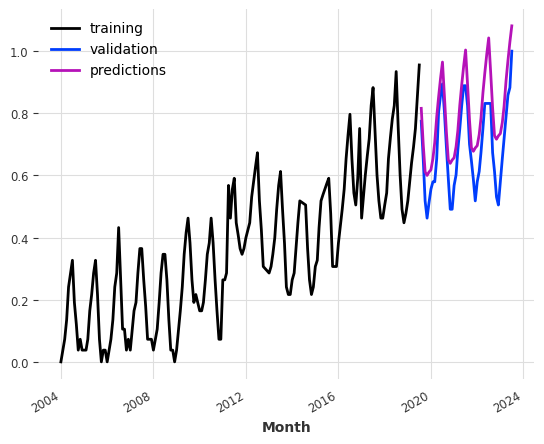

In [ ]:
train.plot(label="training")
val.plot(label="validation")
exp_forecast.plot(label = "predictions")

In [ ]:
from darts.metrics import mape

accuracy = mape(val, exp_forecast)
print(f"Mean Absolute Percentage Error: {accuracy}")

Mean Absolute Percentage Error: 16.13647623029156


Already quite a bit better!

### Multiple models

Darts makes it incredibly easy to loop through a list of models to see which performs best for our task:

In [ ]:
from darts.models import AutoARIMA, Prophet, TBATS

results_dict = {}

for model in [AutoARIMA, Prophet, TBATS]:
    temp = model()
    temp.fit(train)
    preds = temp.predict(len(val))
    accuracy = mape(val, preds)
    results_dict[f"{model}"] = accuracy

10:01:54 - cmdstanpy - INFO - Chain [1] start processing
10:01:54 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
results_dict

{"<class 'darts.models.forecasting.auto_arima.AutoARIMA'>": 20.04339065033156,
 "<class 'darts.models.forecasting.prophet_model.Prophet'>": 16.76503823743529,
 "<class 'darts.models.forecasting.tbats_model.TBATS'>": 6.523111770534111}

It seems TBATS (a model that decomposes a time series into multiple components, including trend, seasonality, and error terms before representing each as a combination of trigonometric functions) has worked best! Could we do any better with some exogenous features though?

### Covariates

Reminder: Covariates refer to external data that can be used as inputs to models to help improve forecasts. In the context of forecasting models, the target is the series to be forecasted/predicted, and the covariates themselves are not predicted. We distinguish three kinds of covariates:

Past covariates are (by definition) covariates known only into the past (e.g. measurements)

Future covariates are (by definition) covariates known into the future (e.g., weather forecasts)

Static covariates are (by definition) covariates constant over time (e.g., product IDs). 

Check out [this page](https://unit8co.github.io/darts/#:~:text=Darts%20is%20a%20Python%20library,%2C%20similar%20to%20scikit%2Dlearn.) to see which models have the availability to fold in past and future covariates. To keep things simple we'll proceed with Arima!



<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/covatiates.png">

Let's try folding in some covariates for our ice_cream sales - what about searches for "hot weather"? (This will essentially act as a proxy for weather forecasts)

In [ ]:
weather_df = pd.read_csv("weather.csv", header = 1)

In [ ]:
weather_df

,Month,hot weather: (United States)
0,2004-01,11
1,2004-02,8
2,2004-03,11
3,2004-04,10
4,2004-05,12
...,...,...
230,2023-03,44
231,2023-04,46
232,2023-05,50
233,2023-06,61


We create a time series just as we did before:

In [ ]:
weather_ts = TimeSeries.from_dataframe(weather_df, time_col="Month", value_cols="hot weather: (United States)")

Let's visualize the two side by side to see if they look aligned:

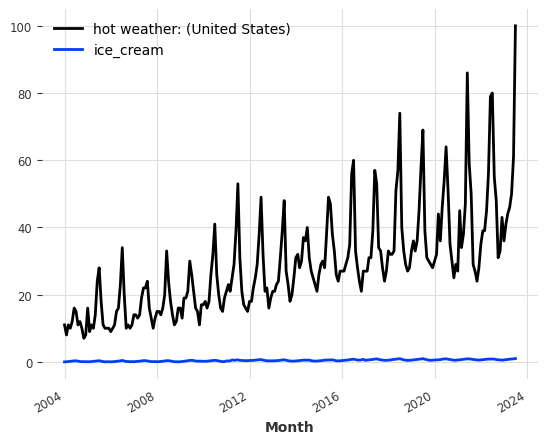

In [ ]:
weather_ts.plot()
scaled_ts.plot()

We'll need to apply the same scaling procedures as before so we can properly compare:

In [ ]:
preproc_weather = ts_transformer.fit_transform(weather_ts)

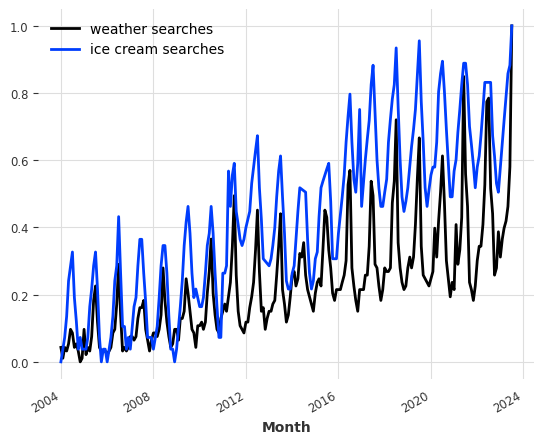

In [ ]:
preproc_weather.plot(label = "weather searches")
scaled_ts.plot(label = "ice cream searches")

There seems to be quite a strong correlation between the two. If we add future predictions for "hot weather" searches (which would probably be quite similar to just a regular weather forecast), does our model get better?

Let's try it with a simple AutoArima Model and no covariates before we add them in:

In [ ]:
model = AutoARIMA()

# w no covariates
model.fit(train)
# predict on our val
base_preds = model.predict(len(val))
# calculate mape
accuracy = mape(val, base_preds)
# add it to a comparison dict
covariates_dict = {}
covariates_dict["no_covariates"] = accuracy

Now we fold in future covariates (i.e. our future prediction data for hot weather)

In [ ]:
covariate_model = AutoARIMA()
# w future covariates only
covariate_model.fit(train, future_covariates = preproc_weather)
base_preds = covariate_model.predict(len(val), future_covariates=preproc_weather)
accuracy = mape(val, base_preds)
covariates_dict[f"future_covariates"] = accuracy

In [ ]:
covariates_dict

{'no_covariates': 20.04339065033156, 'future_covariates': 5.49508164570306}

Our error is down to just versus the original 20%. Darts makes it so easy to fold in as many different covariate series as we want to - all we have to do is `stack()` them (see stack [documentation](https://unit8co.github.io/darts/generated_api/darts.timeseries.html?highlight=stack#darts.timeseries.TimeSeries.stack) if you'd like to have some fun sticking more time series together)!

🚀 In this notebook, you've accomplished the following:

📚 Data Loading and Visualization: You loaded time series data, created Darts TimeSeries objects, and visualized the data using Darts' visualization capabilities.

🔄 Data Manipulation: You performed various operations to manipulate time series data, including handling missing values, resampling, rolling window calculations, and feature engineering.

⏳ Time Series Modeling and Forecasting: You explored different models such as NaiveSeasonal, ExponentialSmoothing, AutoARIMA, Prophet, and TBATS, fitting them to the data and generating forecasts.

🔎 Covariates and Holidays: You learned how to incorporate covariates and holidays into your time series models, leveraging their predictive power to improve forecast accuracy.

🎊 Conclusion: Working with time series doesn't have to be hard! Darts simplifies the process and empowers you to unlock insights from temporal data using an array of tools and models. So, dive in, explore, and unlock the potential of time series analysis! ✨

🌈 Remember to have fun while exploring the captivating world of time series! If you encounter any challenges, Darts provides extensive documentation and a supportive community to assist you along the way. 🌟

Happy forecasting! 🚀😊